In [15]:
# Headers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp

from astropy.io import fits
from astropy.table import Table, Column

import treecorr

In [16]:
def calculate_patch_radius(patch_area_sq_degrees):
    return np.arccos(1-patch_area_sq_degrees*np.pi/(2*180*180))

sq_degrees = 250

patch_radius = calculate_patch_radius(sq_degrees)

# Input Cl's (obtained using Healpy on projected Mice map)

In [17]:
def read_cl():
    l = np.loadtxt('../data/Mice_data/Cell_mice_map.dat', usecols=(0))
    cl = np.loadtxt('../data/Mice_data/Cell_mice_map.dat', usecols=(1))
    return l, cl

l , cl = read_cl()

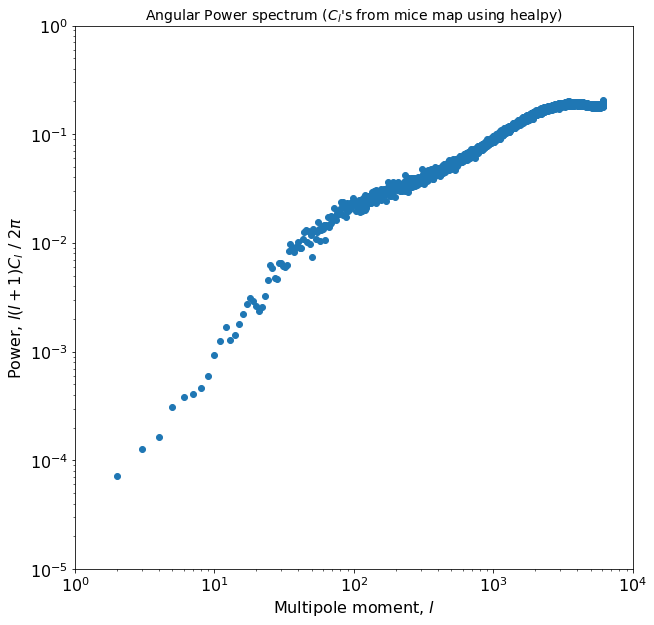

In [18]:
plt.figure(figsize=(10,10))

plt.scatter(l, l*(l+1)*cl/(2*np.pi))
plt.yscale('log')
plt.xscale('log')
plt.xlim(1,10000)
plt.ylim(1e-5,1)
plt.xlabel('Multipole moment, $l$', fontsize=16)
plt.ylabel('Power, $l(l+1)C_l$ / $2π$', fontsize=16)
plt.tick_params(labelsize=16)
plt.title('Angular Power spectrum ($C_l$\'s from mice map using healpy)', fontsize=14)
plt.savefig('./mice_output/plot_output/Angular_power_spectrum_Cl_mice_map_data.pdf')

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


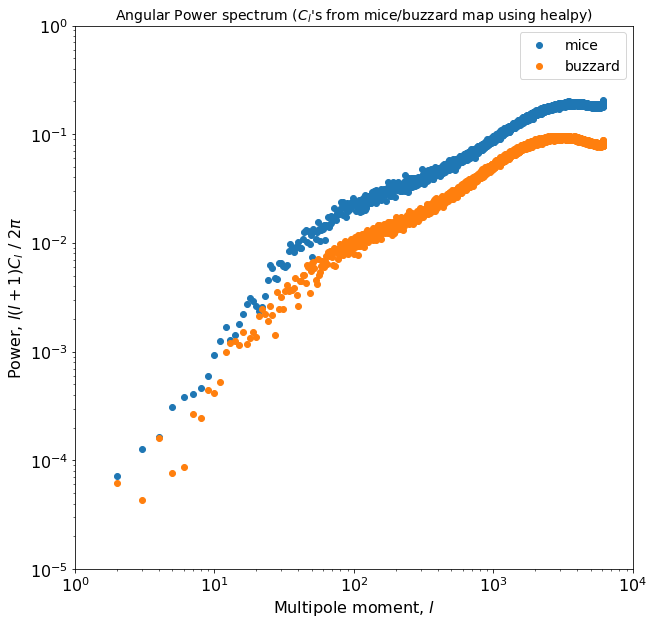

In [22]:
# Comparison of buzzard and mice Cl's obtained using healpy on the maps

density_field_buzzard = hp.fitsfunc.read_map('../data/Buzzard_data/oliver_delta.fits')

#cl_buzzard = hp.sphtfunc.anafast(density_field_buzzard)
cl_buzzard = np.loadtxt('../data/Buzzard_data/Cell_buzzard_map.dat')

plt.figure(figsize=(10,10))

plt.scatter(l, l*(l+1)*cl/(2*np.pi), label='mice')
plt.scatter(l, l*(l+1)*cl_buzzard/(2*np.pi), label='buzzard')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1,10000)
plt.ylim(1e-5,1)
plt.xlabel('Multipole moment, $l$', fontsize=16)
plt.ylabel('Power, $l(l+1)C_l$ / $2π$', fontsize=16)
plt.tick_params(labelsize=16)
plt.title('Angular Power spectrum ($C_l$\'s from mice/buzzard map using healpy)', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.savefig('./mice_output/plot_output/Angular_power_spectrum_Cl_mice_buzzard_map_comparison.pdf')

# Mice map: Visualize Projected matter density Healpy map

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<Figure size 864x864 with 0 Axes>

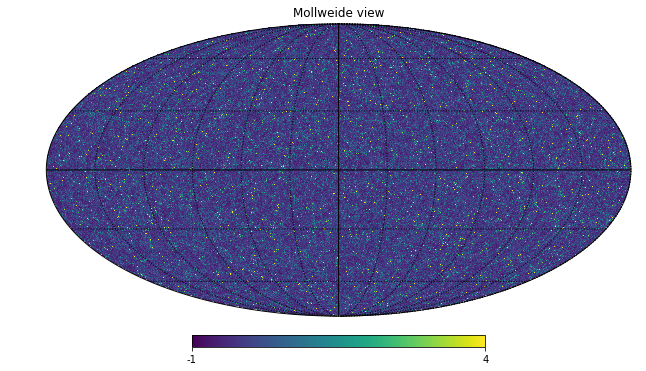

In [5]:
number_field_mice = hp.fitsfunc.read_map('../data/Mice_data/mice_number_field.fits')
mean_number = np.mean(number_field_mice)
density_field_mice = (number_field_mice - mean_number) / mean_number

nside = 2048

plt.figure(figsize=(12,12))
hp.mollview(density_field_mice, min=-1, max=4)
hp.graticule()
plt.savefig('./mice_output/plot_output/density_field_mice_map.pdf')

# Make a single patch of pixels and save with astropy (fits) for feeding into treecorr

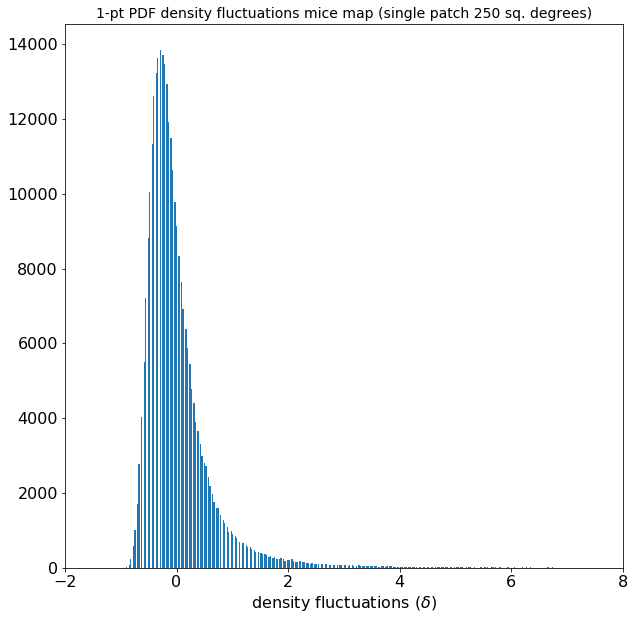

In [6]:
# Choose a random pixel i.e. center of spherical cap around which to take sq_degrees area
disc_center = hp.pix2vec(nside, 1010101)

# radius (in radians) corresponding to area of spherical cap in sky

# find the pixels 
pixels_indices_disc = hp.query_disc(nside, disc_center, patch_radius)

density_field_mice_disc = density_field_mice[pixels_indices_disc]
dec = np.pi/2 - hp.pix2ang(nside, pixels_indices_disc)[0]
RA = hp.pix2ang(nside, pixels_indices_disc)[1]

# for saving into fits file with astropy
RA_data = Column(RA, name='RA', dtype='float') # column having ra
dec_data = Column(dec, name='dec', dtype='float') # column having dec
del_data = Column(density_field_mice_disc, name='del', dtype='float') # column having pixels_disc_values

density_fluctuations_table = Table((RA_data, dec_data, del_data))  
# density_fluctuations_table.show_in_notebook()

density_fluctuations_table.write("./mice_output/single_patch/density_fluctuations_mice_single_patch.fits" , overwrite=True)

# 1-pt PDF of density fluctuations within patch

plt.figure(figsize=(10,10))
plt.hist(density_field_mice_disc, bins=1000)
plt.xlabel('density fluctuations ($δ$)', fontsize=16)
plt.tick_params(labelsize=16)
plt.xlim(-2,8)
plt.title('1-pt PDF density fluctuations mice map (single patch '+str(sq_degrees)+' sq. degrees)', fontsize=14)
plt.savefig("./mice_output/plot_output/1_pt_PDF_single_patch/density_fluctuations_mice_1_pt_PDF_single_patch.pdf")

# TreeCorr: for autocorrelation of the Mice density fluctuations

In [7]:
density_fluctuations = hp.read_cl('./mice_output/single_patch/density_fluctuations_mice_single_patch.fits')

density_fluctuations_RA = density_fluctuations[0,:]
density_fluctuations_dec = density_fluctuations[1,:]
density_fluctuations_del = density_fluctuations[2,:]

cat = treecorr.Catalog(ra=density_fluctuations_RA, dec=density_fluctuations_dec,
                       ra_units='rad', dec_units='rad', k=density_fluctuations_del)

kk = treecorr.KKCorrelation(min_sep=1, max_sep=150, nbins=20, sep_units='arcmin')
kk.process(cat) 
theta_tc = kk.rnom
w_tc = kk.xi

dat = np.array([theta_tc, w_tc])
dat = dat.T
np.savetxt('./mice_output/single_patch/treecorr_angular_correlation_mice_single_patch.txt', dat, delimiter = ' ')

# Comparison of $w(\theta)$ from treecorr and from theoretical $C_l$

In [8]:
def w_theta(theta):
    x = np.cos(theta)
    coeff = (2*l+1)/(4*np.pi)*cl
    w = np.polynomial.legendre.legval(x, coeff)
    return w     

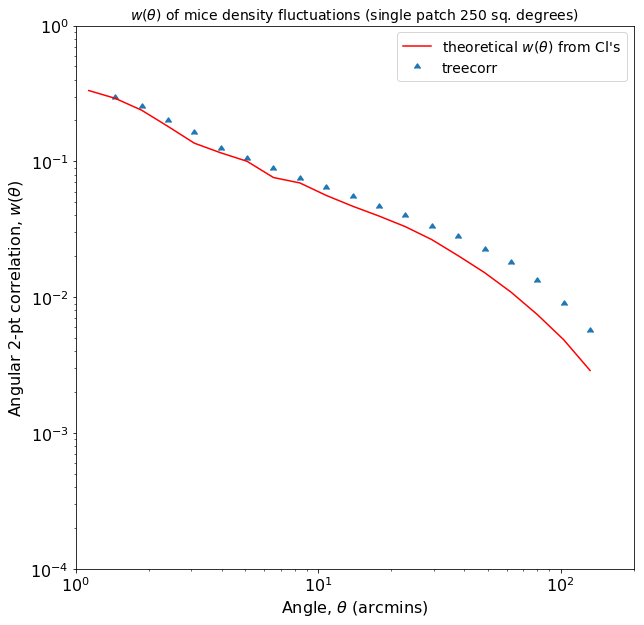

In [11]:
theta_treecorr = np.loadtxt('./mice_output/single_patch/treecorr_angular_correlation_mice_single_patch.txt', usecols=(0)) # in arcmins
w_treecorr = np.loadtxt('./mice_output/single_patch/treecorr_angular_correlation_mice_single_patch.txt', usecols=(1)) # w(theta)

plt.figure(figsize=(10,10))
plt.scatter(theta_treecorr,w_treecorr, marker=10, label='treecorr')
plt.plot(theta_treecorr, w_theta(theta_treecorr/60*np.pi/180), c='r', label='theoretical $w(θ)$ from Cl\'s')
plt.xlim(1,200)
plt.ylim(1e-4, 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Angle, $θ$ (arcmins)', fontsize=16)
plt.ylabel('Angular 2-pt correlation, $w(θ)$', fontsize=16)
plt.tick_params(labelsize=16)
plt.title('$w(\\theta)$ of mice density fluctuations (single patch '+str(sq_degrees)+' sq. degrees)', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.savefig('./mice_output/plot_output/treecorr_and_theoretical_angular_correlation_mice_single_patch.pdf')